# LGT2 Unit 11 Day01 - In-Class Assignment:
# Nucleon Charges in Lattice QCD
### <p style="text-align: right;"> &#9989; Put your name here.</p>
#### <p style="text-align: right;"> &#9989; Put your group member names here.</p>

---
## Goals of this assignment

The goals of this assignment are:

* Extend our analysis from the pre-class notebook to include multi-state fit forms.
* Perform a simultaneous fit over mutliple separation times to improve the reliability of our nucleon charge.
* Analyze our results and apply this procedure to extract different nucleon charges; namely the isovector axial and tensor charges. 

## Assignment instructions

Work with your group to complete this assignment. Upload the assignment to each university's assignement system at the end of class.
The class has a diverse background of students with different experties; if the topic aligned well with your research topic, help the instructor to guide other students who learn about these topics for the very first time. There will be classes that others are the experts and can return the favor.
**Make sure everyone's name is listed in everyone's notebook before moving on**

In [2]:
# import libraries
import math 
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

---
Below, you'll find some basic functions used in the pre-class assignment: 
* `jack()` applies jackknife resampling to a 1D array of data. 
* `jack_stats()` takes in a 1D or 2D array of jackknife resampled data and returns the mean and error.
* `EM()` takes in a 1D of (length T) and calculate the effective mass (length T-1). 

Throughout this notebook, you'll also encounter additional functions and coding templates to guide you. Whenever new code is introduced, take a moment to understand how it works!

In [3]:
# no need to change anything in this cell
def jack(data):
    n = len(data)
    jack_data = [(np.sum(data)-data[i])/(n-1) for i in range(n)]
    return np.array(jack_data)

In [4]:
# no need to change anything in this cell
def jack_stats(jack_data):
    jack_data = np.asarray(jack_data) 
    
    if jack_data.ndim == 1:
        n = len(jack_data)
        mean  = np.mean(jack_data)
        error = np.sqrt( (n - 1) / n * np.sum((jack_data - mean) ** 2) )
        return mean, error
    
    elif jack_data.ndim == 2: 
        m, n  = jack_data.shape  # m: rows (time), n: columns (subsets)
        mean  = np.mean(jack_data, axis=1)
        error = np.sqrt( (n - 1) / n * np.sum((jack_data - mean[:, None]) ** 2, axis=1) )
        return mean, error
    else: raise ValueError("Input data must be either 1D or 2D array.")

In [5]:
# no need to change anything in this cell
def EM(data):
    T = len(data)
    Meff = [-1 * math.log(data[t+1]/data[t]) for t in range(0,T-1)]
    return np.array(Meff)

---
# Part 0: Pre-Class Notebook Comparison
Before diving into the in-class notebook, take a few moments to compare your solutions from the pre-class assignment. Work in small groups to ensure everyone is on the same page. 

### Task 0.0: Compare Pre-Class Solutions
In the markdown cell below, discuss any differences you observe in the following results with your groupmates:
* Step 1: Compare your plots of the raw correlator data and the reconstructed effective mass. Do they look the same across all group members?
* Step 2: Compare the mean and error of `E0`, obtained from fitting the two-point correlator using the two-state fit form. Record your and your groupmates' values in the markdown cell. 
* Step 3: Compare the mean and error of `O00`, extracted from fitting the three-point correlator with the one-state fit form. Record your and your groupmates' values in the markdown cell. 

&#9998; *Student Solution...*

Please add your and your groupmates' mean and error for E0 and O00 here.

----
# Part 1: Extracting the Isovector Vector Charge


## Part 1.1 Introduction to LHPC Data

HDF5 (Hierarchical Data Format, version 5) files, denoted by `.h5`, are widely used in computational physics for storing large, structured datasets. This format organizes data hierarchically, similar to a file directory:
* **Groups**: Act like folders, categorizing datasets.
* **Datasets**: Multi-dimensional arrays containing numerical data.
* **Attributes**: Metadata, such as physical parameters or lattice configurations

HDF5 enables efficient data access, compression, and portability across computing platforms. In this notebook, we will analyze Lattice Hadron Physics Collaboration (LHPC) data stored in an HDF5 file. Please download the dataset from the following link: [LHPC Data](https://drive.google.com/file/d/1Dj9cFdLjX6EuVhgUOAeDZ0BqQhFE2ipj/view?usp=share_link).

#### Structure of the LHPC Data
The **two-point correlation functions** are stored under the path `/hspectrum/PX0_PY0_PZ0/` and are saved as datasets with the shape $(\text{n}_{\text{cfgs}}, T)$, where  $\text{n}_{\text{cfgs}} = 427$ represents the number of gauge field configurations, and $T = 64$ corresponds to the full temporal extent of the lattice. The full volume of this lattice is $L^3 \times T = 64^3 \times 64$ and the spin and parity projection matrices are given by: 

$$ \tag{1.1}
\Gamma_{\text{pol}} = \frac{1}{2} \left( 1 + \gamma_4 \right) \left( 1 - i \gamma_3 \gamma_5 \right)
$$

The **three-point correlation functions** are stored under `/building_blocks/PX0_PY0_PZ0/t{t}/{U,D}/d{d}/g{g}`, where each directory component encodes information about the correlation function parameters. The variable `t{t}` represents the separation time, which takes values `{10, 13, 16}`. The `{U,D}` component specifies the quark content, indicating whether the correlator corresponds to the up (U) or down (D) quark, which are used to construct isovector charges. The `d{d}` component denotes the spatial or temporal displacement of the quark bilinear operator, with `d0` representing no displacement. The `g{g}` component encodes the Gamma matrix structure as a 4-bit integer, where different values correspond to specific gamma matrix products. This specific correspondence follows the notation outlined in the [Chroma Documentation](https://homepages.uni-regensburg.de/~cos14742/lqcd-1/web_chroma_tutorial_short/chroma_gamma_matrices.pdf). 

### Task 1.1.1: Reading in the Raw Correlator Data
In the pre-class assignment, we looked at how to extract a simple vector charge. Now, we'll look into extracting the **isovector vector charge** from the provided LHPC Data. Before begining our analysis, we need to examine the raw lattice correlator data to understand what we're working with and ensure we're reading the data in correctly. 
* Step 1: Finish writing the function that reads in the two-point and three-point correlators from the HDF5 file. Your function should be able to do the following: 
    * Apply jackknife resampling to the correlator data.
    * Take the difference between the up and down quark contributions of the three-point correlator data. 
    * Return the jackknife resampled data along with its mean and error.  
    * For convenience of reading in three-point correlator data in later parts of the assingment, make the separation time, `tsep`, and the gamma matrix index, `g`, arguments of your function.
* Step 2: Globaly define the number of configurations in the dataset and identify the time range associated with the two-point and three-point correlation functions. 
* Step 3: Use your function to read the two-point correlator data and plot its mean along with its error. Display the plot on a logarithmic scale and ensure all axes are properly labeled. 
* Step 4: Use your function to read the three-point correlator data for the vector charge (`g8`) with a separation time of $t_{\text{sep}} = 10$. For the vector charge, you'll want to take the real part of your three-point correlator data. Plot the mean and error of the three-point correlator data, ensuring all axes are properly labeled.

&#9998; *Student Solution...*

In [6]:
# Step 1 Solution:
def process_zero_momentum_data(tsep=None, g=None, part='real'):
    file_path = "fine_zero.h5"
    
    with h5py.File(file_path, 'r') as f:
        if tsep is None: 
            dataset_path = # fill this in...
            data = np.array(f[dataset_path]).T 

        else:
            dataset_up   = # fill this in...
            dataset_down = # fill this in...
            
            data_up   = np.array(f[dataset_up]).T
            data_down = np.array(f[dataset_down]).T
            
            data = # fill this in...
    
    if part == 'real': # fill this in...
    if part == 'imag': # fill this in...
    
    data_dict = {t: {'jack': # fill this in...
                     'mean': # fill this in...
                     'std':  # fill this in... for t in range(len(data))}

    jackknife_array = np.array([data_dict[t]['jack'] for t in data_dict])
    mean, std = jack_stats(jackknife_array)    
    return jackknife_array, mean, std

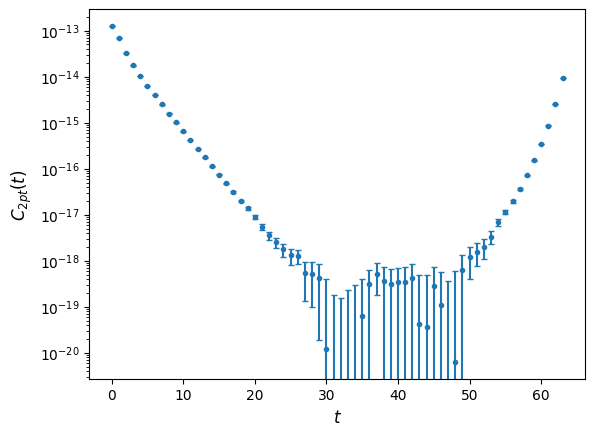

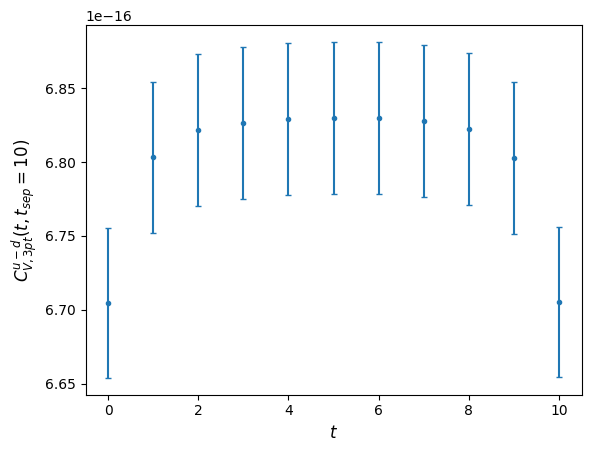

In [8]:
ncfgs = # fill this in...

# what arguments go here?
C2pt_jack, C2pt_mean, C2pt_std = process_zero_momentum_data() 
C3pt_jack, C3pt_mean, C3pt_std = process_zero_momentum_data() 

# plot your results... 

### Task 1.1.2: Construct the Ratio Plot 
* Step 1: Using the ratio function you wrote in the pre-class assignment and the jackknifed two-point and three-point correlators, plot the mean and error of the ratio. Make sure to center your plot by setting the x-axis as $t_{\text{ins}} - t_{\text{sep}}/2$.
* Step 2: Estimate the ground state matrix element by taking the average across the platue region of your ratio.

&#9998; *Student Solution...*

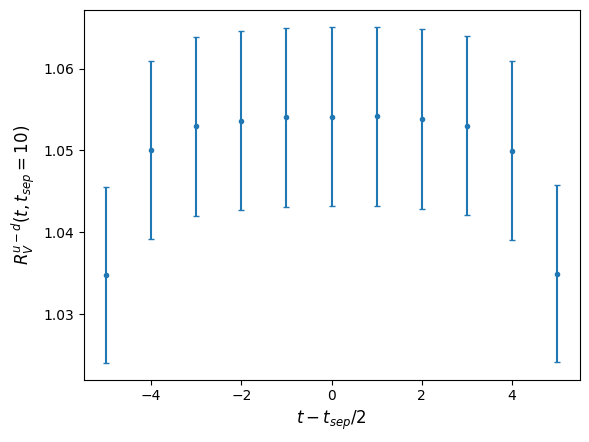

In [9]:
tsep = # fill this in...

R_mean, R_std = # your ratio function goes here... 

# plot your results...

----
## Part 1.2: Fitting the Correlators
In the pre-class assignment, we performed a one-state fit for the three-point correlator, which provided an initial estimate of the relevant matrix element. However, this approach does not fully account for excited-state contamination, which can introduce systematic biases when extracting the ground-state contribution. To achieve a more precise and reliable result, we now extend our analysis by incorporating excited-state effects into the fitting procedure.

### The Two-Point Correlator
The two-point correlator encodes information about the energy spectrum of the system. Unlike the single-exponential form used in a one-state fit, the two-state fit accounts for both the ground state and the first excited state: 

$$ \tag{2.1}
C_{\text{2pt}}^{\text{model}} = |A_0|^2 e^{-E_0 t} + |A_1|^2 e^{-E_1 t}
$$

where $E_0$ ($A_0$) and $E_1$ ($A_1$) are the ground and excited state energies (amplitudes). By including the second exponential term, we aim to isolate and subtract the excited-state contributions, leading to a more accurate determination of the ground-state matrix element. Recall that we can validate the fit of our two-point correlator by reconstructing the effective mass, 

$$ \tag{2.2}
M_{\text{eff}}(t) = - \ln \left( \frac{C_{\text{2pt}}(t)}{C_{\text{2pt}}(t+1)} \right)
$$

which provides an approximate estimate of the dominant energy contribution at a given time slice, $t$. In the limit where the ground-state contribution dominates $(t >> 1)$, the correlator behaves as a single exponential, and the effective mass approaches a constant value corresponding to the ground-state energy, $E_0$. By plotting $M_{\text{eff}}(t)$, we can visually identify a stable region (plateau) where the ground state dominates and choose an appropriate fitting window for our two-point correlator. 

### Task 1.2.1: Fit the Two-Point Correlator
* Step 1: Plot the effective mass using the LHPC two-point correlator data.
* Step 2: Finish writing the model function, `C2pt_model(t, A0, E0, A1, dE)`, to fit the two-point correlator using a **two-state fit form** like we did in the pre-class assignment. Then, use this function to fit the data with the provided fitting function, `Fit2ptCorr(fit_range)`. 
* Step 3: Work with your groupmates to determine an appropriate fitting range by considering excited state contamination and signal-to-noise ratio. Plot the reconstructed effective mass with error bands.
* Step 4: Compare your fitted ground state energy to the value listed in Table II of [arXiv:1903.06487v3](https://arxiv.org/pdf/1903.06487). How close is your result?

&#9998; *Student Solution...*

In [10]:
def C2pt_model(t, A0, E0, A1, dE):
    E1 = E0 + abs(dE) # Ensures E1 > E0
    return # fill this in...

In [11]:
# no need to change anything in this cell
def Fit2ptCorr(fit_range):
    tmin, tmax = fit_range
    
    param_names = ['A0', 'E0', 'A1', 'dE']
    fit_params = {key: [] for key in param_names}
    
    for cfg in range(0,ncfgs):    
        popt, pcov = curve_fit(lambda t, *params: C2pt_model(t, *params),
                               xdata = np.arange(tmin,tmax+1),
                               ydata = C2pt_jack[tmin:tmax+1,cfg],
                               sigma = C2pt_std[tmin:tmax+1],
                               p0    = [1e-5,0.5,1e-5,0.5],
                               maxfev= 50000)
        
        for key, value in zip(param_names, popt):
            fit_params[key].append(value)
            
    return fit_params 

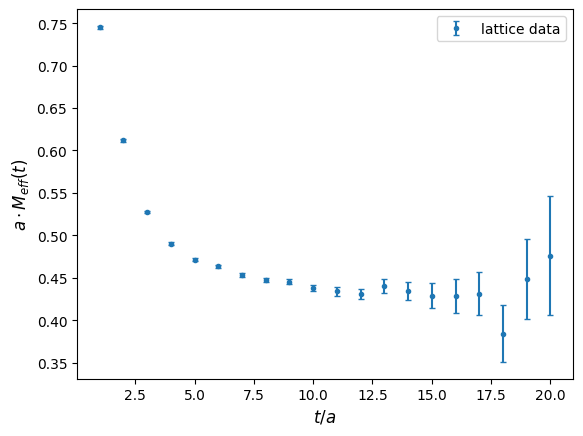

In [13]:
fit_range = # fill this in...
tmin, tmax = fit_range
times = np.arange(tmin, tmax+2)

params = Fit2ptCorr(fit_range)
A0, E0, A1, dE = (params[key] for key in ['A0', 'E0', 'A1', 'dE'])

fits = # fill this in...
fit_mean, fit_std = jack_stats(fits)

EM_jack = # fill this in...
EM_mean, EM_std = jack_stats(EM_jack)

# plot your results... 

## The Three-Point Correlator
In our pre-class assignment, we approximated the three-point correlator using only the leading contribution, assuming dominance of the ground state. However, a more accurate representation accounts for excited-state contamination by including additional terms from a two-state model. The full two-state expression for the three-point correlator is given by:

$$ \tag{2.3}
C_{\text{3pt}}^{\text{model}} (t, t_{\text{sep}}) = \mathcal{M}_{00} |A_0|^2 e^{-E_0 t_{\text{sep}}} + \mathcal{M}_{01} |A_0| |A_1| e^{-E_0 t_{\text{sep}}} e^{-E_1 (t_{\text{sep}} - t)}
$$

$$ + \mathcal{M}_{10} |A_0| |A_1| e^{-E_1 t_{\text{sep}}} e^{-E_0 (t_{\text{sep}} - t)} + \mathcal{M}_{11} |A_1|^2 e^{-E_1 t_{\text{sep}}}
$$

where $\mathcal{M}_{10} = \mathcal{M}_{01}^*$ due to the hermiticity of the operators involved. This formulation includes contributions from both the ground state and the first excited state, allowing for a more accurate extraction of matrix elements. Recall that we can validate our three-point correlator fits by reconstructing the ratio: 

$$ \tag{2.4}
R (t, t_{\text{sep}}) = \frac{ C_{\text{3pt}} (t, t_{\text{sep}})}{C_{\text{2pt}}(t_{\text{sep}})}
$$

This ratio serves as a useful diagnostic tool because it isolates the matrix element of interest while reducing dependence on normalization factors and statistical fluctuations. The two-point correlator in the denominator helps mitigate variations due to the overlap factors, making the ratio more sensitive to the excited-state effects present in the three-point correlator. 

### Task 1.2.2: Fit the Three-Point Correlator
* Step 1: Modify the fit function, `C3pt_model(tsep, tins, A0, E0, A1, dE, O00, O10)`, and the fitting routine, `Fit3ptCorr(tsep)`, from the pre-class assignment to incorporate contributions from the excited state terms, $\mathcal{M}_{10}$ and $\mathcal{M}_{01}^*$. This approach, which we refer to as the two-state2 fit form, includes two-state contributions but fits only two matrix elements.
* Step 2: Reconstruct the ratio plot with errorbands using this updated fit form. Be sure to properly label your axes. 
* Step 3: Compare the fitted ground state matrix element to your previous estimate from Part 1. Discuss any observed differences... are they expected? Why or why not?

&#9998; *Student Solution...*

In [14]:
def C3pt_model(tsep, tins, A0, E0, A1, dE, O00, O10):
    E1 = E0 + abs(np.array(dE)) # enfore E1 > E0
    
    return # fill this in...

In [15]:
def Fit3ptCorr(tsep):
    param_names = ['O00'] # update this line.... 
    fit_params = {key: [] for key in param_names}
    
    for cfg in range(ncfgs): 
        popt, pcov = curve_fit(lambda t, O00: C3pt_model(tsep, t, A0[cfg], E0[cfg], A1[cfg], dE[cfg], O00), # update this line...
                                xdata = np.arange(1,tsep),
                                ydata = C3pt_jack[1:tsep,cfg],
                                sigma = C3pt_std[1:tsep],
                                p0 = [0.1], # update this line...
                                maxfev = 500000)
        
        for key, value in zip(param_names, popt):
            fit_params[key].append(value)
    
    return fit_params

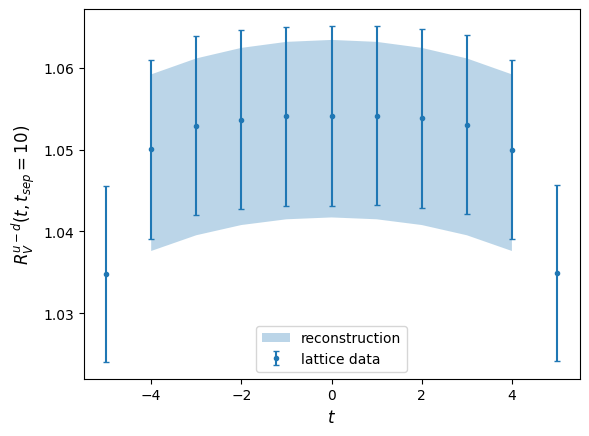

In [16]:
# finish writing the code in this cell... 
params = Fit3ptCorr(tsep)
O00, O10 = (params[key] for key in ['O00', 'O10'])

fit_jack = # fill this in...
fit_mean, fit_std = jack_stats(fit_jack)

# plot your results... 

----
## Part 1.3: Extending to Multiple Separation Times

In Parts 1.2, we fit the three-point correlator using a single separation time $t_{\text{sep}}$. However, this approach has limitations... When relying on just one $t_{\text{sep}}$, contributions from excited states can introduce systematic uncertainties, making it harder to extract the ground-state matrix element reliably. To improve the accuracy of our results, we will now incorporate multiple separation times into a simultaneous fit. This approach helps in two key ways:
1. Reduces systematic uncertainties – By analyzing trends across multiple $t_{\text{sep}}$, we can better distinguish the ground-state contribution from excited states. 
2. Improves statistical precision – Fitting all separation times together provides better constraints on parameters, leading to more stable results. 

### Task 1.3.1: Implement the Simultaneous Fit
In this task, you will extend your fitting procedure to incorporate multiple separation times. Follow these steps:
* Step 1: Load the three-point correlator data for $t_{\text{sep}} = \{10, 13, 16\}$ from the LHPC HDF5 file. (Hint: Organizing the data into a dictionary indexed by $t_{\text{sep}}$, where each entry stores the jackknife resampled data, mean, and standard deviation, will simplify this process, but feel free to use whatever framework is easiest for you!)

* Step 2: Modify the three-point fitting function to simultaneously fit data from multiple separation times. For each separation time $t_{\text{sep}}$, we want to organize the data into a single structure that can be used for fitting. To achieve this, follow the outline below:

    > * Sub-Step 1:  For each separation time $t_{\text{sep}}$, extract the valid insertion times: $t_{\text{ins}} = \{1, 2, ..., t_{\text{sep}} - 1\}$. Combine these into a single list that contains all insertion times from all separation times. This list will be used for fitting and should include insertion times from $t_{\text{sep}} = 10, 13$, and $16$.  
    > * Sub-Step 2: Since each insertion time $t_{\text{ins}}$ is associated with a specific $t_{\text{sep}}$, create a **matching list** of separation times. So, for **each $t_{\text{sep}}$**, store a list of the same length as the number of insertion times, where each entry has the corresponding $t_{\text{sep}}$ value. 
    > > **Example Structure:**  
         For $t_{\text{sep}} = 10$, the valid insertion times are $t_{\text{ins}} = \{1, 2, ..., 9\}$. The corresponding portion of the separation time list should contain **9 elements**, all equal to **10**. If we repeat this for $t_{\text{sep}} = 13$ and $16$, we obtain: 
    > >        $$t_{\text{sep}} = [10, 10, ..., 10, 13, 13, ..., 13, 16, 16, ..., 16]$$  
            This ensures that each insertion time is properly linked to its separation time.  
   > * Sub-Step 3: Extract the **standard deviation** of the data for each $t_{\text{sep}}$. Concatenate these into a **single list** of length $(t_{\text{sep}} - 1)$ for each $t_{\text{sep}}$. This will ensure that the fitting function has a continuous dataset for all separation times.  
   > * Sub-Step 4: For each configuration at each separation time, extract the jackknife resampled data. Concatenate these into a single list of length $t_{\text{sep}} - 1$ for each $t_{\text{sep}}$. This forms the input data for the simultaneous fitting procedure.  

* Step 3: Perform the simultaneous fit and plot the reconstructed ratio with errorbands. Be sure to properly label all of your axes.

&#9998; *Student Solution...*

In [17]:
tsep_values = [10, 13, 16]
C3pt_data = {}
for tsep in tsep_values:
    data_jack, data_mean, data_std = process_zero_momentum_data(# fill this in... )
    C3pt_data[tsep, g] = {'jack': data_jack, 'mean': data_mean, 'std': data_std}

In [18]:
def Fit3ptCorr(tsep_values, g):
    
    combined_tins  = []
    combined_tsep  = []
    combined_sigma = []
    
    for tsep in tsep_values:
        time_slice = np.arange(# fill this in... )
        combined_tins.extend(time_slice)
        combined_tsep.extend(  # fill this in... )
        combined_sigma.extend( # fill this in... )
    
    combined_tins  = np.array(combined_tins)
    combined_tsep  = np.array(combined_tsep)
    combined_sigma = np.array(combined_sigma)
    
    param_names = ['O00', 'O10']
    fit_params = {key: [] for key in param_names}
    
    for cfg in range(ncfgs): 
        combined_data = # fill this in...
        combined_time = np.vstack((combined_tsep, combined_tins))
        
        def fit_func(x, *params):
            tsep, tins = x
            return C3pt_model(tsep, tins, A0[cfg], E0[cfg], A1[cfg], dE[cfg], *params)

        # Perform the fit
        popt, pcov = curve_fit(fit_func,
                xdata=combined_time,
                ydata=combined_data,
                sigma=combined_sigma,
                p0=[0.1,0.1],
                maxfev=500000)
        
        for key, value in zip(param_names, popt):
            fit_params[key].append(value)
        
    return fit_params

In [19]:
def Reconstruct_Ratio(tsep_values, g):
    
    fit_params = Fit3ptCorr(tsep_values, g)
    O00, O10 = [fit_params[key] for key in ['O00', 'O10']]
    
    R =  # fill this in...
    
    
    # you can use this to make your errorbands match the color of the data

    plt.figure()
    color_cycle = plt.cm.tab10.colors
    num_colors = len(color_cycle)
    for i,tsep in enumerate(tsep_values):
        color = color_cycle[i % num_colors] 
        
        fit_jack = # fill this in...
        fit_mean, fit_std = jack_stats(fit_jack)
        
        # plot your results... 

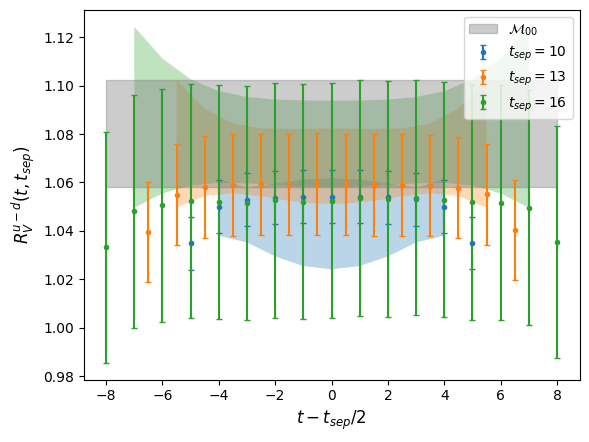

In [20]:
tsep_values = [10,13,16]
Reconstruct_Ratio(tsep_values,g=8)

### Task 1.3.2: Analyze your Results
Congratulations! You've just extracted your first **isovector vector charge**! Let's take a moment to look at our results....
* Step 1: In your ratio plot, what do you notice happening as the separation time of each ratio increases? What value are we approaching and what happens to the quality of the data? 
* Step 2: Compare your fitted ground-state matrix element to your previous result from the single separation time fit in Part 2. What do you observe?

&#9998; *Student Solution...*

Add your responses to the questions above in this cell... 

----
# Part 2: Extracting the Isovector Axial and Tensor Charges

Having developed a framework for multi-state fitting and simultaneous fits across multiple separation times and successfully extracting the isovector vector charge, we can now take a look at the axial and tensor charges. The isovector axial charge ($g_A^{u-d}$)  and isovector tensor charge ($g_T^{u-d}$)  describe the axial and tensor interactions of quarks inside the nucleon, and are essential for understanding the nucleon’s role in both Standard Model (SM) and Beyond the Standard Model (BSM) physics. They are defined through nucleon matrix elements of the axial-vector and tensor currents, which can be computed non-perturbatively using two-point and three-point correlation functions from Lattice QCD. 

#### Isovector Axial Charge
> The isovector axial charge is a key parameter in weak interactions and its precise determination is crucial for extracting the axial coupling constant in nucleon decay experiments. It is defined via the nucleon matrix element of the axial-vector current,
> 
> $$
\langle N(\vec{p}',s') | \vec{J}_A^\mu | N (\vec{p},s) \rangle = g_A^q \bar{u}_N (\vec{p},s) \gamma^{\mu} \gamma_5 u_N (\vec{p},s)
$$
>     
> where $| N (\vec{p},s) \rangle$ is the nucleon state with some momentum $\vec{p}$ and spin $s$, $u_N (\vec{p},s)$ is the nucleon spinor, and the axial-vector current is given by $\vec{J}_A^\mu  = \bar{q} \Gamma_A q = \bar{q} \gamma^{\mu} \gamma_5 q$. The isovector nature of $g_A^{u-d}$ means that it quantifies the difference between the up and down quark contributions to the nucleon axial charge. 

#### Isovector Tensor Charge
> The isovector tensor charge is important for probing novel interactions in searches for BSM physics, particularly in electric dipole moment (EDM) experiments. Additionally, it is relevant for global analyses of transversity parton distribution functions (PDFs), which play a role in understanding the spin structure of the nucleon in deep inelastic scattering and Drell-Yan processes. It is defined from the nucleon matrix element of the tensor current, 
> 
> $$
\langle N(\vec{p},s) | \vec{J}_T^\mu | N (\vec{p},s) \rangle = g_T^q \bar{u}_N (\vec{p},s) \sigma^{\mu \nu} u_N (\vec{p},s)
$$
> 
> where the tensor current is given by $\vec{J}_T^\mu = \bar{q} \Gamma_T q = \bar{q} \sigma^{\mu \nu} q$ with $\sigma_{\mu \nu} = \frac{i}{2} [\gamma^\mu, \gamma^\nu ]$. Again, the isovector nature of $g_T^{u-d}$ reflects the difference between up and down quark contributions to the nucleon tensor charge. 

### Task 2.1: Repeat the Analysis for the Isovector Axial Charge
In this task, we will follow the same procedures used previously, but now applying it to the axial charge using the appropriate gamma matrix, indexed as `g11`, for the axial current operator.
* Step 1: Read in the three-point correlator data associated with the axial charge. 
* Step 2: Call the functions we developed throughout Part 1 to fit the new three-point correlator and reconstruct the ratio plot with errorbands. Again, be sure to properly label all of your axes. 

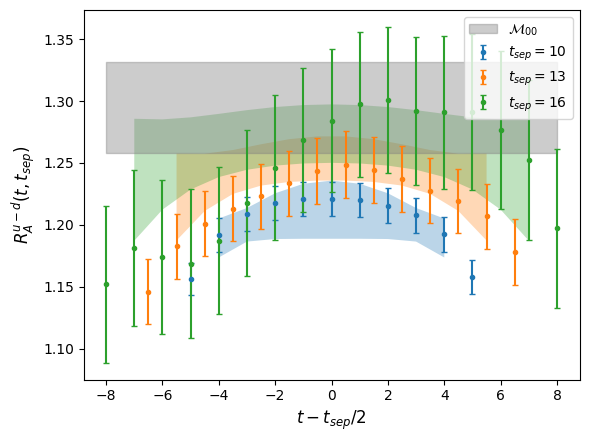

In [21]:
Reconstruct_Ratio(tsep_values, g=11)

### Task 2.2: Analyze your Results for the Isovector Axial Charge
Congratulations! You've just extracted your first **isovector axial charge**! Let's take a moment to look at our results....
* Step 1: In your ratio plot, what do you notice happening as the separation time of each ratio increases? Why does or doesn't this make sense? 
* Step 2: Compare your fitted ground-state matrix element to the value listed in Table IV of [arXiv:1903.06487v3](https://arxiv.org/pdf/1903.06487). How close is your result?

&#9998; *Student Solution...*

Add your responses to the questions above in this cell... 

### Task 2.3: Repeat the Analysis for the Isovector Tensor Charge
Apply the same procedure, but now use `g3` which correpsonds to the tensor charge.  
* Step 1: Read in the appropriate three-point correlator data for extracting the tensor charge. 
* Step 2: Call the functions we developed throughout Part 1 to fit the new three-point correlator and reconstruct the ratio plot with errorbands. Again, be sure to properly label all of your axes. 

&#9998; *Student Solution...*

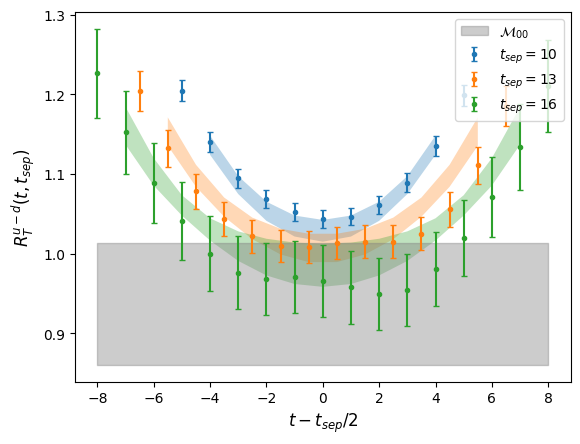

In [22]:
Reconstruct_Ratio(tsep_values, g=3)

### Task 2.4: Analyze your Results for the Isovector Tensor Charge
Congratulations! You've just extracted your first **isovector tensor charge**! Let's take a moment to look at our results....
* Step 1: In your ratio plot, what do you notice happening as the separation time of each ratio increases? Why does or doesn't this make sense? 
* Step 2: Compare your fitted ground-state matrix element to the value listed in Table IV of [arXiv:1903.06487v3](https://arxiv.org/pdf/1903.06487). How close is your result?

&#9998; *Student Solution...*

Add your responses to the questions above in this cell... 

### Task 2.5 (Bonus): The Isovector Scalar Charge
With the framework we've developed, it's very easy to extract the **isovector scalar charge**, $g_S^{u-d} = g_S^u - g_S^d$, as well... 
* Step 1: Identify the appropriate gamma matrix for the three-point correlator needed to extract the isovector scalar charge by consulting the [Chroma Documentation](https://homepages.uni-regensburg.de/~cos14742/lqcd-1/web_chroma_tutorial_short/chroma_gamma_matrices.pdf). 
* Step 2: Repeat the previous steps to reconstruct the ratio plot with errorbands and determine the value of $g_S^{u-d}$.
* Step 3: Compare your fitted ground-state matrix element to the value listed in Table IV of [arXiv:1903.06487v3](https://arxiv.org/pdf/1903.06487). How close is your result?

&#9998; *Student Solution...*

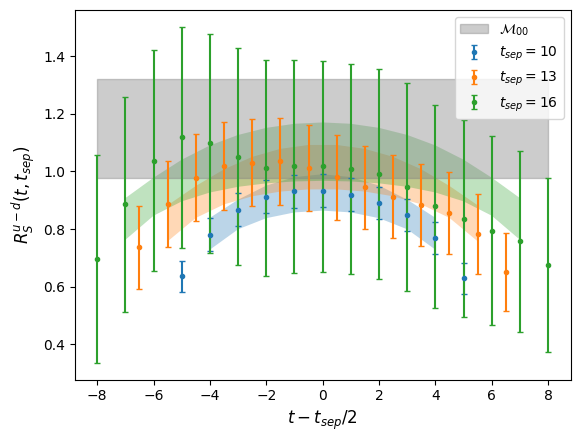

In [23]:
Reconstruct_Ratio(tsep_values, g=0)

---
# Part 3 (Optional): Introduction to Nucleon Moments
Now that we have successfully extracted isovector charges, we can extend our analysis to nucleon moments. These moments provide deeper insights into the internal structure of the nucleon by describing how momentum and spin are distributed among its constituent quarks and gluons. Mathematically, nucleon moments arise from matrix elements of local operators and can reveal fundamental properties such as the momentum fraction carried by quarks and higher-order quark-gluon interactions.One of simple nucleon moments to consider is the first moment of the unpolarized parton distribution function (PDF), which measures the fraction of the nucleon's total momentum carried by quarks: 

$$ \tag{3.1}
\langle x \rangle_{q} = \int_0^1 dx \; x \; q(x)
$$

where $q(x)$ represents the probability density for finding a quark carrying a momentum fraction  of the nucleon. Similar to the nucleon charges, we can also look at the difference between the up and down quark contributions in our nucleon moment - this is unsurprisingly referred to as the isovector nucleon moment, which captures the difference between the contributions of up and down quarks: 

$$ \tag{3.2}
\langle x \rangle_{u-d} = \int_0^1 dx \; x \left[u(x) - d(x) \right]
$$

where $u(x)$ and $d(x)$ denote the momentum distributions of up and down quarks, respectively. To extract nucleon moments, we use leading-twist operators, which are gauge-invariant, symmetric, and traceless combinations of quark bilinear currents with covariant derivatives. These operators allow us to isolate physically relevant contributions while minimizing contamination from higher-twist effects. The general form of such an operator is:

$$ \tag{3.3}
\mathcal{O}_q^{\mu_1, \mu_2, ..., \mu_n} = \bar{q} \gamma^{\{ \mu_1} i D^{\mu_2} ... i D^{\mu_n \}} q
$$ 

where... 
* $\bar{q}\gamma^{\mu} q$ is the quark billinear current
* $D^\mu = \partial^\mu - i g A^\mu$ is the covariant derivative
* $\{ ... \}$ enforces symmetry and tracelessness, ensuring a leading-twist contribution

These operators can be categorized into different channels based on their Lorentz structure, some of which iclude: the vector (V), axial (A), and tensor (T) channels, corresponding to unpolarized, polarized, and transversity PDFs, respectively. For a more in-depth discussion on these operators and their applications in nucleon moment calculations, refer to [arXiv:2401.05360](https://arxiv.org/abs/2401.05360).

#### Constructing a Simple Operator 
For now, let's just focus on one simple vector operator, given by: 

$$\tag{3.4}
\mathcal{O}_{V_2} = \frac{1}{\sqrt{2}} \left( \mathcal{O}^V_{33} - \mathcal{O}^V_{44} \right)
$$

which is a linear combination of the two bilocal vector operators, $\mathcal{O}^V_{33}$ and $\mathcal{O}^V_{44}$. The first operator, $\mathcal{O}^V_{33}$, involves the spatial component $(\mu = 3 , \nu = 3)$, meaning it is related to dynamics along the z-direction, while the second operator, $\mathcal{O}^V_{44}$, involves the temporal component $(\mu = 4 , \nu = 4)$. To construct this operator, I introduce "building blocks", a term which should sound familiar from the HDF5 file structure discussed in Part 1 of this notebook. These building blocks, denoted by $\mathcal{B^\Gamma_{z,\mu}}$, are mathematically defined in terms of quark and antiquark currents connected by a single gauge link: 

$$ \tag{3.5}
\mathcal{B}^\Gamma_{q, +\mu} = \langle N(P') | \overline{q}_z U^\dagger_{z+\hat{\mu}, \mu} \Gamma q_{z+\hat{\mu}} | N(P) \rangle
$$

$$ \tag{3.6}
\mathcal{B}^\Gamma_{q, -\mu} = \langle N(P') | \overline{q}_z U^\dagger_{z-\hat{\mu}, \mu} \Gamma q_{z-\hat{\mu}} | N(P) \rangle
$$

where the index $\mu$ indicates a forward ($+\mu$) or backward ($-\mu$) shift in the $\mu$-direction. The three-point correlation function involving $\mathcal{O}_{\mu \nu}^V$ can be written in momentum space in terms of these building block as: 

> Spatial Index: $\nu = z = 3$,
    $$\tag{3.7} \langle N(P') | \mathcal{O}^V_{\mu z} | N(P) \rangle = \frac{1}{4} \bigg( \mathcal{B}^{\gamma_\mu}_{q,-z}(1+e^{i\frac{2\pi q_z}{L_z}}) - \mathcal{B}^{\gamma_\mu}_{q,+z}(1+e^{-i\frac{2\pi q_z}{L_z}}) \bigg) 
$$
> where $q_{\mu}$ is the four-momentum transfer and $L_\mu$ is the represents the lattice dimension. 

> Temportal Index: $\nu = t = 4$, 
$$ \tag{3.8} \langle N(P') | \mathcal{O}^V_{\mu t} | N(P) \rangle = \frac{1}{4} \bigg( \mathcal{B}^{\gamma_\mu}_{q,-t} - \mathcal{B}^{\gamma_\mu}_{q,t} - \mathcal{B}^{\gamma_\mu}_{q+\hat{t},t} + \mathcal{B}^{\gamma_\mu}_{q-\hat{t},-t} \bigg) $$

In practice then, one needs to call building blocks with a particular gamma matrix $\gamma_\mu$ and momentum $q$ and combine them with the appropriate forwards or backwards shift in the $\nu$ direction to obtain the operator of interest, $\mathcal{O}^V_{\mu\nu}$.

### Task 5.1: Extracting an Isovector Nucleon Moment
To extract $\langle x \rangle_{u-d}$ from the lattice, we can use LHPC data that includes nonzero momentum, allowing us to look at quark momentum distributions within the nucleon. Download the following data, which has the same structure discussed in Part 1 of this notebook: [non-zero momentum LHPC Data](https://drive.google.com/file/d/1AdgXLJRCMz5y25n6ZPVeKJsHsNx-cEDE/view?usp=share_link). Using the provided data try to build the leading-twist operator given in Euqation 5.4 and see if you can reproduce the results from [arXiv:2401.05360](https://arxiv.org/abs/2401.05360). Consult the [Chroma Documentaiton](https://homepages.uni-regensburg.de/~cos14742/lqcd-1/web_chroma_tutorial_short/chroma_gamma_matrices.pdf) to determine which gamma matrix, $\gamma^\mu$, you will need to use. Once you have the three-point correlator containing this operator, you should be able to simply re-use the functions developed in this notebook to extract the first moment from the nucleon matrix element. 

&#9998; *Student Solution...*

In [241]:
# Loading Data from HDF5
def load_building_blocks(file_path, tsep):
    base_path = f"building_blocks/PX-1_PY0_PZ0/t{tsep}"
    BB_files = {
        'U': {'dz_b': f"{base_path}/U/dz_b/g4", 'dz_f': f"{base_path}/U/dz_f/g4",
              'dt_b': f"{base_path}/U/dt_b/g8", 'dt_f': f"{base_path}/U/dt_f/g8"},
        'D': {'dz_b': f"{base_path}/D/dz_b/g4", 'dz_f': f"{base_path}/D/dz_f/g4",
              'dt_b': f"{base_path}/D/dt_b/g8", 'dt_f': f"{base_path}/D/dt_f/g8"}}
    with h5py.File(file_path, 'r') as f:
        for paths in BB_files.values():
            for path in paths.values():
                if path not in f:
                    raise KeyError(f"Dataset {path} not found in the file.")
        BB_data = {flavor: {key: np.real(np.array(f[path])).T for key, path in paths.items()} for flavor, paths in BB_files.items()}
    return BB_data

# # Compute Vector Operator
# def compute_O_V(BB_data, flavor):
#     O_V_33 = 0.5  * (BB_data[flavor]['dz_b'] - BB_data[flavor]['dz_f'])
#     O_V_44 = 0.25 * (BB_data[flavor]['dt_b'] - BB_data[flavor]['dt_f']
#                     - np.roll(BB_data[flavor]['dt_f'], shift=1, axis=0) # exclude endpoints
#                     + np.roll(BB_data[flavor]['dt_b'], shift=-1, axis=0))
#     return np.real((O_V_33 - O_V_44) / np.sqrt(2))

def compute_O_V(BB_data, flavor):
    O_V_33 = 0.5 * (BB_data[flavor]['dz_b'] - BB_data[flavor]['dz_f'])
    print(O_V_33)
    dt_fwd = BB_data[flavor]['dt_b']  # BB_t(1)
    dt_bwd = BB_data[flavor]['dt_f']  # BB_{-t}(1)
    # Forward shift: BB_t(0) (next time slice)
    dt_fwd_shifted = np.zeros_like(dt_fwd)
    dt_fwd_shifted[:-1] = dt_fwd[1:]
    # Backward shift: BB_{-t}(-1) (previous time slice)
    dt_bwd_shifted = np.zeros_like(dt_bwd)
    dt_bwd_shifted[1:] = dt_bwd[:-1]
    O_V_44 = 0.25 * (dt_bwd - dt_fwd - dt_fwd_shifted + dt_bwd_shifted)
    return np.real((O_V_33 - O_V_44) / np.sqrt(2))

# # Compute Vector Operator
# def compute_O_V(BB_data, flavor):
#     O_V_33 = 0.5 * (BB_data[flavor]['dz_b'] - BB_data[flavor]['dz_f'])
#     # Implementing the correct forward and backward shifts for temporal index t (ν = 4)
#     dt_fwd = BB_data[flavor]['dt_b']  # BB_t(1)
#     dt_bwd = BB_data[flavor]['dt_f']  # BB_{-t}(1)
#     dt_fwd_shifted = np.roll(dt_fwd, shift=-1, axis=0)  # BB_t(0) -> shifted forward
#     dt_bwd_shifted = np.roll(dt_bwd, shift=1, axis=0)   # BB_{-t}(-1) -> shifted backward
#     # Exclude endpoints by setting wrapped values to zero
#     dt_fwd_shifted[-1] = 0  # Prevent forward shift from wrapping
#     dt_bwd_shifted[0]  = 0  # Prevent backward shift from wrapping
#     O_V_44 = 0.25 * (dt_bwd - dt_fwd - dt_fwd_shifted + dt_bwd_shifted)
#     return np.real((O_V_33 - O_V_44) / np.sqrt(2))

# Process Vector Operator
def process_vector_operator(file_path, tsep):
    BB_data = load_building_blocks(file_path, tsep)
    O_V = compute_O_V(BB_data, 'U') - compute_O_V(BB_data, 'D')
    O_V_jack = jack(O_V)
    O_V_mean, O_V_std = jack_stats(O_V_jack)
    return O_V_jack, O_V_mean, O_V_std

In [242]:
file_path = "fine_boost.h5"
tsep_values = [10, 13, 16]
C3pt_data = {}

for tsep in tsep_values:
    data_jack, data_mean, data_std = process_vector_operator(file_path, tsep)
    C3pt_data[tsep] = {'jack': data_jack, 'mean': data_mean, 'std': data_std}
    # plot_results(tsep, data_mean, data_std)

[[-5.60532659e-17 -4.90828457e-17 -4.08063315e-17 ... -4.31387893e-17
  -5.02358675e-17 -3.17820101e-17]
 [-4.84554374e-17 -4.42029048e-17 -2.73427100e-17 ... -3.70381760e-17
  -3.92997866e-17 -2.62102389e-17]
 [-5.17547200e-17 -4.13840511e-17 -2.18944201e-17 ... -3.41348351e-17
  -4.15936070e-17 -2.83990931e-17]
 ...
 [-3.74308109e-17 -3.51157238e-17 -2.50414190e-17 ... -2.90950093e-17
  -4.79314962e-17 -1.60705956e-17]
 [-4.23490256e-17 -3.39442500e-17 -2.96665113e-17 ... -3.24963510e-17
  -4.60971826e-17 -2.32342186e-17]
 [-5.39780869e-17 -4.94718127e-17 -4.48748640e-17 ... -4.37308541e-17
  -5.62762473e-17 -4.14739880e-17]]
[[-3.33974269e-17 -2.21702154e-17 -1.98928621e-17 ... -2.13001978e-17
  -2.58201846e-17 -1.70189989e-17]
 [-3.16333728e-17 -1.89397511e-17 -1.18404663e-17 ... -1.89005059e-17
  -1.90902233e-17 -1.30596348e-17]
 [-3.12478867e-17 -1.88981187e-17 -1.24169960e-17 ... -1.94303034e-17
  -2.45771509e-17 -1.18165097e-17]
 ...
 [-2.32928107e-17 -1.70291083e-17 -8.1018147

(11,)


<ErrorbarContainer object of 3 artists>

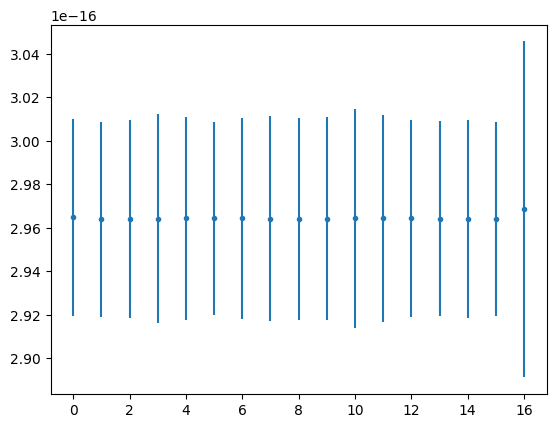

In [243]:
print(C3pt_data[10]['mean'].shape) # m: rows (time), n: columns (subsets)

plt.figure()
plt.errorbar(np.arange(tsep+1), C3pt_data[tsep]['mean'], yerr=C3pt_data[tsep]['std'], fmt='.')

Estimated E0 = 0.44843245907617113
Fitted E0 = 0.43958531262471506



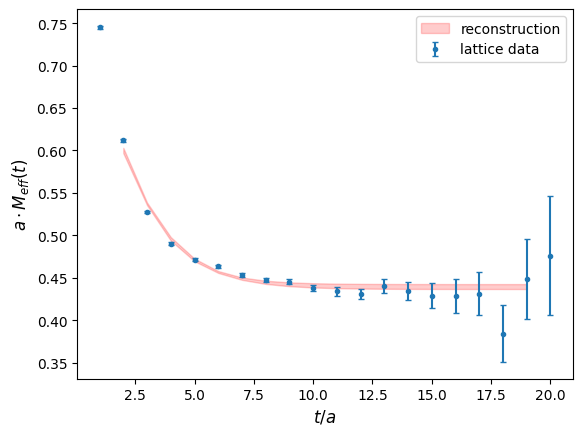

In [225]:
# Fitting Two-Point Correlator
def Fit2ptCorr(fit_range):
    tmin, tmax = fit_range
    param_names = ['A0', 'E0', 'A1', 'dE']
    fit_params = {key: [] for key in param_names}
    
    for cfg in range(ncfgs):    
        popt, _ = curve_fit(lambda t, *params: C2pt_model(t, *params),
                            xdata=np.arange(tmin, tmax + 1),
                            ydata=C2pt_jack[tmin:tmax + 1, cfg],
                            sigma=C2pt_std[tmin:tmax + 1],
                            p0=[1e-5, 0.5, 1e-5, 0.5])
        
        for key, value in zip(param_names, popt):
            fit_params[key].append(value)
            
    return fit_params 

# Solution for Two-Point Correlator Fit
fit_range = [2, 19]
tmin, tmax = fit_range
params = Fit2ptCorr(fit_range)
A0, E0, A1, dE = (params[key] for key in ['A0', 'E0', 'A1', 'dE'])

# Compute Fits and Plot
fits = np.array([EM(C2pt_model(np.arange(tmin, tmax+2), *cfg_params)) for cfg_params in zip(A0, E0, A1, dE)]).T
EM_jack = np.array([EM(C2pt_jack[1:tmax+3, cfg]) for cfg in range(ncfgs)]).T
fit_mean, fit_std = jack_stats(fits)
EM_mean, EM_std = jack_stats(EM_jack)

print(f"Estimated E0 = {np.average(EM_mean[tmin:tmax+1])}")
print(f"Fitted E0 = {jack_stats(E0)[0]}\n")

plt.figure()
plt.errorbar(np.arange(1, tmax+2), EM_mean, yerr=EM_std, fmt='.', capsize=2, label='lattice data')
plt.fill_between(np.arange(tmin, tmax+1), fit_mean + fit_std, fit_mean - fit_std, color='red', alpha=0.2, label='reconstruction')
plt.ylabel(r"$a \cdot M_{eff}(t)$", fontsize=12)
plt.xlabel(r'$t / a$', fontsize=12)
plt.legend(fontsize=10)
plt.show()

In [226]:
def Fit3ptCorr(tsep_values):
    combined_tins, combined_tsep, combined_sigma = [], [], []
    
    for tsep in tsep_values:
        time_slice = np.arange(1, tsep)
        combined_tins.extend(time_slice)
        combined_tsep.extend([tsep] * len(time_slice))
        combined_sigma.extend(C3pt_data[tsep]['std'][1:tsep])
    
    combined_tins = np.array(combined_tins)
    combined_tsep = np.array(combined_tsep)
    combined_sigma = np.array(combined_sigma)
    
    param_names = ['O00', 'O10']
    fit_params = {key: [] for key in param_names}
    
    for cfg in range(ncfgs):
        combined_data = np.concatenate([C3pt_data[tsep]['jack'][1:tsep, cfg] for tsep in tsep_values])
        combined_time = np.vstack((combined_tsep, combined_tins))
        
        def fit_func(x, *params):
            tsep, tins = x
            return C3pt_model(tsep, tins, A0[cfg], E0[cfg], A1[cfg], dE[cfg], *params)

        # Perform the fit
        popt, _ = curve_fit(fit_func, combined_time, combined_data, sigma=combined_sigma, p0=[0.1, 0.1], maxfev=500000)
        
        for key, value in zip(param_names, popt):
            fit_params[key].append(value)
    
    return fit_params

In [227]:
def Reconstruct_Ratio(tsep_values):
    fit_params = Fit3ptCorr(tsep_values)
    O00, O10 = fit_params['O00'], fit_params['O10']
    O00_mean, O00_std = jack_stats(O00)
    
    print(f"Fitted O00 = {O00_mean} +/- {O00_std}")
    
    R = {}
    for tsep in tsep_values:
        R_jack = np.array([C3pt_data[tsep]['jack'][t] / C2pt_jack[tsep] for t in range(1, tsep)])
        R_mean, R_std = jack_stats(R_jack)
        R[tsep] = {'jack': R_jack, 'mean': R_mean, 'std': R_std}
    
    plt.figure()
    color_cycle = plt.cm.tab10.colors
    num_colors = len(color_cycle)
    
    for i, tsep in enumerate(tsep_values):
        color = color_cycle[i % num_colors]
        
        R_jack_fitted = []
        for cfg in range(ncfgs):
            C2pt_fitted = C2pt_model(tsep, A0[cfg], E0[cfg], A1[cfg], dE[cfg])
            C3pt_fitted = np.array([C3pt_model(tsep, t, A0[cfg], E0[cfg], A1[cfg], dE[cfg], O00[cfg], O10[cfg]) for t in np.arange(1, tsep)])
            R_jack_fitted.append(C3pt_fitted / C2pt_fitted)
        
        fit_jack = np.array(R_jack_fitted).T
        fit_mean, fit_std = jack_stats(fit_jack)
        
        plt.errorbar(np.arange(1, tsep) - tsep / 2, R[tsep]['mean'][0:tsep + 1], yerr=R[tsep]['std'][0:tsep + 1], fmt='.', capsize=2, label=fr'$t_{{sep}} = {tsep}$', color=color)
        plt.fill_between(np.arange(1, tsep) - tsep / 2, fit_mean + fit_std, fit_mean - fit_std, alpha=0.3, color=color)
    
    plt.fill_between(np.arange(1, tsep) - tsep / 2, O00_mean + O00_std, O00_mean - O00_std, color='gray', alpha=0.4, label=r'$\mathcal{M}_{00}$')
    plt.xlabel(r"$t - t_{sep}/2$", fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.show()

Fitted O00 = -20.69011654463515 +/- 0.2201626849241323


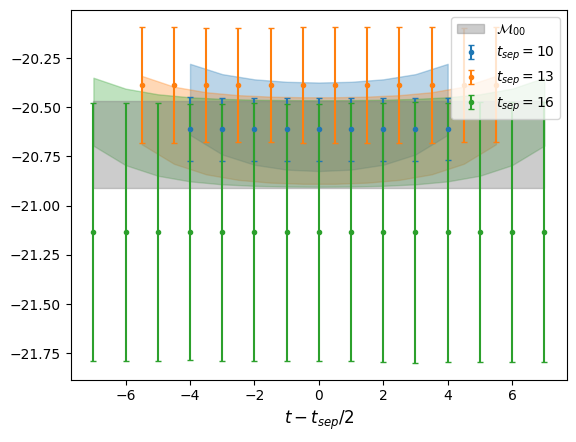

In [228]:
tsep_values = [10, 13, 16]
Reconstruct_Ratio(tsep_values)

-----------------------
# Congratulations, you're done!

Submit this assignment by uploading it to the course [Gradescope](https://www.gradescope.com/courses/987121).

&#169; Copyright 2025,  Michigan State University Board of Trustees